# 1. Imports

In [1]:
import pandas as pd
import numpy  as np
import math
from   datetime import timedelta

import warnings as wrg

import matplotlib.pyplot as plt
from   matplotlib.gridspec import GridSpec
import seaborn as sns
from SRLib.Utilities import graph

from statsmodels.stats import api as sms

# 2. Help Functions | Settings

In [2]:
wrg.filterwarnings('ignore')


# 3.Load data

In [3]:
data_raw = pd.read_csv( '../data/ab_data.csv' )

## 3.1 Initial conversion

In [4]:
data_raw.timestamp = pd.to_datetime( data_raw.timestamp )

# 4. EDA

In [5]:
display( data_raw.head() )
display( data_raw.describe().T )
display( data_raw[['group', 'landing_page']].describe().T )
display( f'Conjunto contendo {data_raw.shape[0]} linhas e {data_raw.shape[1]} colunas' )

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


,count,mean,std,min,25%,50%,75%,max
user_id,294478.0,787974.124733,91210.823776,630000.0,709032.25,787933.5,866911.75,945999.0
converted,294478.0,0.119659,0.324563,0.0,0.00,0.0,0.00,1.0


,count,unique,top,freq
group,294478,2,treatment,147276
landing_page,294478,2,old_page,147239


'Conjunto contendo 294478 linhas e 5 colunas'

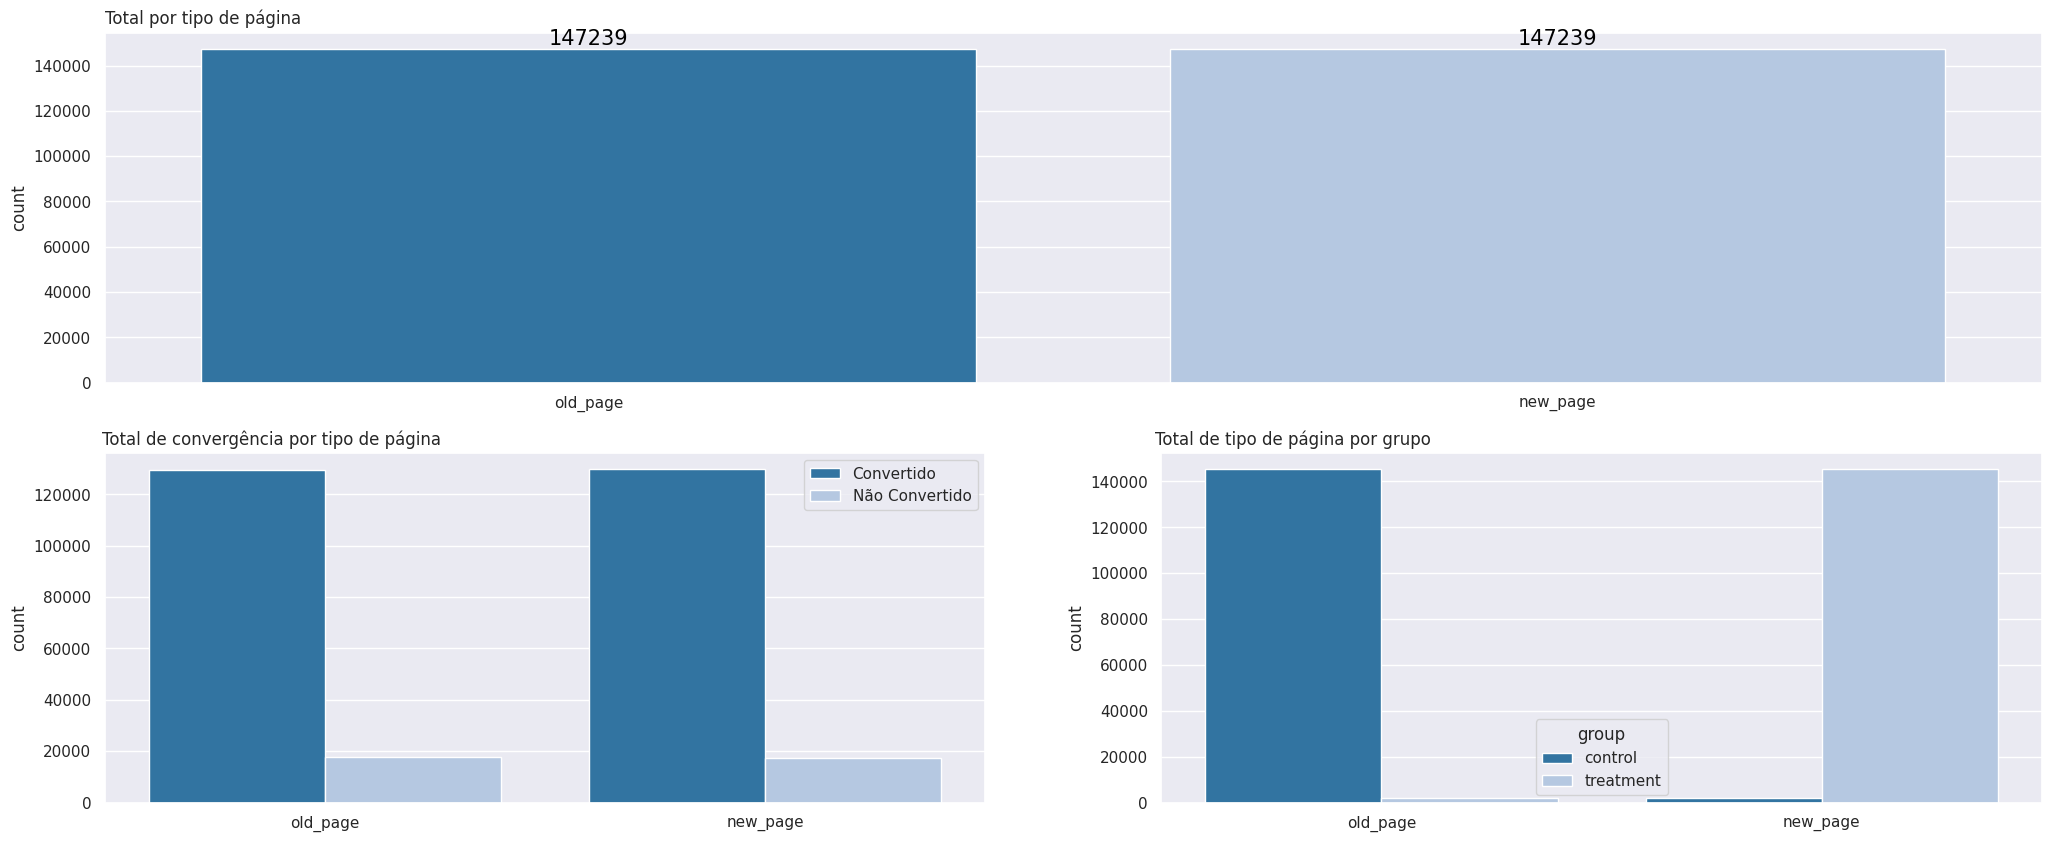

In [6]:
from tempfile import tempdir


sns.set( rc={'figure.figsize' : (25,10)} )
spec = GridSpec(2,2)

#First chart
plt.subplot( spec[0,:] )
ax = sns.countplot(
    data    = data_raw,
    x       = 'landing_page',
    palette = 'tab20'
);
graph.plot_values_vbar( ax )
plt.title( 'Total por tipo de página', x = 0.051 );
plt.xlabel( None );

#Second chart
plt.subplot( spec[1,0] )
ax = sns.countplot(
    data    = data_raw,
    x       = 'landing_page',
    hue     = 'converted',
    palette = 'tab20'
);
plt.legend( ['Convertido', 'Não Convertido'] );
plt.title( 'Total de convergência por tipo de página', x = 0.19 );
plt.xlabel( None );


#Third chart
plt.subplot( spec[1,1] )
ax = sns.countplot(
    data    = data_raw,
    x       = 'landing_page',
    hue     = 'group',
    palette = 'tab20'
);
plt.title( 'Total de tipo de página por grupo', x = 0.15 );
plt.xlabel( None );


# 5. Design de Experimentos

## 5.1 Formulação de hipóteses

## 5.2 Parâmetros do experimento

In [83]:
### Nível de Confiança
conf_lv    = 0.95
### Nível de Significância
sign_lv    = 0.05

# Proporção da página atual e da nova página
p1 = 0.13
p2 = 0.15

### Tamanho do efeito
tam_efeito = sms.proportion_effectsize( p1, p2 )
display( f'Valor do tamanho do efeito calculado:  {tam_efeito}' )

### Poder estatístico
power  = 0.80

'Valor do tamanho do efeito calculado:  -0.0576728617308947'

In [84]:
#Tamanho da amostra
sample_n =sms.NormalIndPower().solve_power(
    effect_size = tam_efeito,
    power       = power,
    alpha       = sign_lv,
)
sample_n = math.ceil( sample_n )
display( f'O tamanho da amostra necessária de cada grupo (controle e tratamento) é: {sample_n}' )
display( f'Sendo necessária uma amostra total de: {2*sample_n}' )

'O tamanho da amostra necessária de cada grupo (controle e tratamento) é: 4720'

'Sendo necessária uma amostra total de: 9440'

##### Funil quanto ao envio e resposta aos e-mails

In [85]:
convertion_rate = 0.10 #Referente a taxa de resposta aos e-mails enviados
tot_email       = math.ceil( ( 2*sample_n / convertion_rate ) )
print(f'Será necessário o envio de {tot_email} e-mails ')

Será necessário o envio de 94400 e-mails 


#### Cálculo da média de clientes a serem atingidos e tempo médio

In [86]:
from datetime import datetime


temp = data_raw[['user_id', 'timestamp']]
temp['day'] = temp.timestamp.dt.day
temp = temp[['day', 'user_id']].groupby('day').count().reset_index()
media = math.ceil( temp.user_id.mean() )
display( f'Média de acessos diários: {media}, sendo necessários ~ {math.ceil(tot_email / media)} dias para atingir a meta de envio de e-maisl' )



'Média de acessos diários: 12804, sendo necessários ~ 8 dias para atingir a meta de envio de e-maisl'

---

- Como será preciso de uma amostra de 1246 por grupo (2492 no total) e a taxa de conversão é de 13%, será necessário aproximadamente 29.318 envios para atingir a meta;
- Sendo necessários assim, 3 dias para atingir todas as amostras necessárias.